# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tabulate import tabulate
import openpyxl

# Loading Data

In [ ]:
# Load the dataset
df = pd.read_excel("version 3.xlsx") # Use the path to your data version that you want to analyze

# Convert 'Date' to datetime format (assuming dayfirst=True for DD.MM.YY format)

In [3]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [4]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with invalid or missing datetime values
df = df.dropna(subset=['Date'])

# Ensure the datetime column is sorted (optional but recommended for time series data)
df = df.sort_values(by='Date')

# Filter out any dates beyond your desired range (e.g., up to 2024)
df = df[df['Date'].dt.year <= 2024]

# Column name

In [ ]:
print("\nColumns ")
print(df.columns)

# Data type for different column

In [ ]:
print("\n Data Types")
print(df.dtypes)

# Handling Missing Value

## Missing Dates How many

In [ ]:
# Create a date range from the start date to the end date
start_date = df['Date'].min()
end_date = df['Date'].max()
date_range = pd.date_range(start=start_date, end=end_date)

# Find missing dates
missing_dates = date_range.difference(df['Date'])

# Print missing dates
print("Missing dates:")
print(missing_dates)
# Print the number of missing dates
print("Number of missing dates:", len(missing_dates))

# Create 'Year' and 'Month' columns
df['Year'] = df['Date'].apply(lambda x: x.year)
df['Month'] = df['Date'].apply(lambda x: x.month)

# Reorder columns to bring 'Year' and 'Month' to the 3rd and 4th positions
cols = list(df.columns)
cols.insert(2, cols.pop(cols.index('Year')))
cols.insert(3, cols.pop(cols.index('Month')))
df = df[cols]

## How Many Missing Values

In [8]:
print("\n Missing Values ")
print(df.isnull().sum())


 Missing Values 
Date                                           0
Day of the week                                0
Year                                           0
Month                                          0
Max. Demand at eve. peak (Generation end)      0
Max. Demand at eve. peak (Sub-station end)     0
Highest Generation (Generation end)            0
Minimum Generation (Generation end)            0
Day-peak Generation (Generation end)           0
Evening-peak Generation (Generation end)       0
Minimum Generation Forecast up to 8:00 hrs.    0
Maximum Temperature in Dhaka was               0
Gas/LF limitation                              0
Coal supply Limitation                         0
Low water level in Kaptai lake                 0
Plants under shut down/ maintenance            0
Dhaka_demand                                   0
Dhaka_supply                                   0
Dhaka_load                                     0
Chattogram_demand                              0
Ch

## Removing The missing values

In [9]:
# List of columns to interpolate
columns_to_interpolate = [
    'Minimum Generation Forecast up to 8:00 hrs.',
    'Maximum Temperature in Dhaka was',
    'Gas/LF limitation',
    'Coal supply Limitation',
    'Low water level in Kaptai lake',
    'Plants under shut down/ maintenance'
]

# Interpolate missing values in the specified columns
for column in columns_to_interpolate:
    df[column] = df[column].interpolate(method='linear', limit_direction='both', limit_area='inside')

In [10]:
print("\n Missing Values ")
print(df.isnull().sum())


 Missing Values 
Date                                           0
Day of the week                                0
Year                                           0
Month                                          0
Max. Demand at eve. peak (Generation end)      0
Max. Demand at eve. peak (Sub-station end)     0
Highest Generation (Generation end)            0
Minimum Generation (Generation end)            0
Day-peak Generation (Generation end)           0
Evening-peak Generation (Generation end)       0
Minimum Generation Forecast up to 8:00 hrs.    0
Maximum Temperature in Dhaka was               0
Gas/LF limitation                              0
Coal supply Limitation                         0
Low water level in Kaptai lake                 0
Plants under shut down/ maintenance            0
Dhaka_demand                                   0
Dhaka_supply                                   0
Dhaka_load                                     0
Chattogram_demand                              0
Ch

## Missing Max. Demand at eve. peak (Generation end)==0

In [ ]:
# Create df1 with only 'Date' and 'Max. Demand at eve. peak (Generation end)' columns
df1 = df[['Date', 'Evening-peak Generation (Generation end)']]

# Filter df1 to include only rows where 'Max. Demand at eve. peak (Generation end)' is zero
df1 = df1[df1['Evening-peak Generation (Generation end)'] == 0]

# Print df1
print("Filtered DataFrame (df1) with zero demand at evening peak (Generation end):")
print(df1)

In [12]:
# Identify the indices of zero values in 'Max. Demand at eve. peak (Generation end)'
zero_indices = df[df['Max. Demand at eve. peak (Generation end)'] == 0].index

# Function to interpolate the value based on previous and next 10 non-zero values
def interpolate_value(index):
    non_zero_values = df['Max. Demand at eve. peak (Generation end)'].replace(0, np.nan).dropna()
    prev_values = non_zero_values[non_zero_values.index < index].tail(10)
    next_values = non_zero_values[non_zero_values.index > index].head(10)
    combined_values = pd.concat([prev_values, next_values])
    interpolated_value = combined_values.interpolate(method='linear').iloc[10]  # Interpolate and take the middle value
    sub_station_value = df.at[index, 'Max. Demand at eve. peak (Sub-station end)']
    final_value = (interpolated_value + sub_station_value) / 2
    return int(round(final_value))

# Impute zero values
for index in zero_indices:
    df.at[index, 'Max. Demand at eve. peak (Generation end)'] = interpolate_value(index)

# Save the DataFrame to an Excel file
df.to_excel("imputed_output.xlsx", index=False)

In [ ]:
# Create df1 with only 'Date' and 'Max. Demand at eve. peak (Generation end)' columns
df1 = df[['Date', 'Max. Demand at eve. peak (Generation end)']]

# Filter df1 to include only rows where 'Max. Demand at eve. peak (Generation end)' is zero
df1 = df1[df1['Max. Demand at eve. peak (Generation end)'] == 0]

# Print df1
print("Filtered DataFrame (df1) with zero demand at evening peak (Generation end):")
print(df1)

# Statistics Summary

In [ ]:
print("\n Summary Statistics")
print(df.describe())

# Total Holiday count in all years

In [ ]:
print("\nUnique Holiday Categories")
print(df['Holiday_cat'].value_counts())

In [ ]:
print("\nUnique Holiday Names")
print(df['Holiday name'].value_counts())

# Year wise evening Peak demand

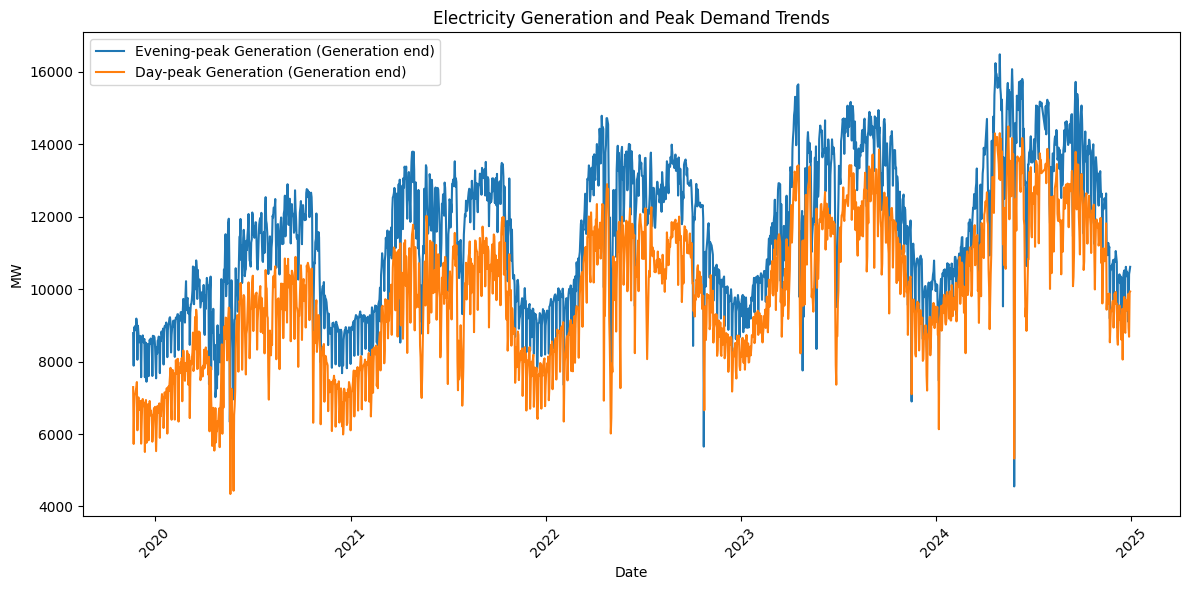

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import io
# Select columns to plot
columns_to_plot = [
    "Evening-peak Generation (Generation end)",
    "Day-peak Generation (Generation end)"
]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
for col in columns_to_plot:
    ax.plot(df["Date"], df[col], label=col)

# Styling
ax.set_title("Electricity Generation and Peak Demand Trends")
ax.set_xlabel("Date")
ax.set_ylabel("MW")
ax.legend()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()

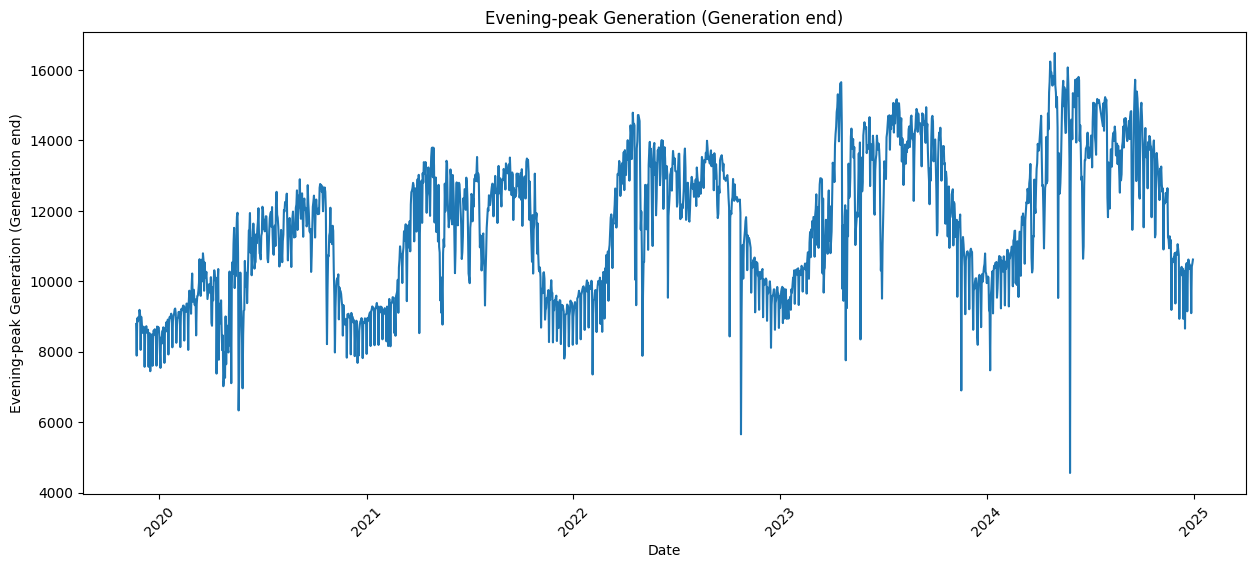

In [12]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='Date', y='Evening-peak Generation (Generation end)', data=df)
plt.title('Evening-peak Generation (Generation end)')
plt.xticks(rotation=45)
plt.show()

# Fixing Outliers

In [18]:
# Final strict hybrid outlier correction using rolling median and 30% deviation
from pandas.api.types import is_numeric_dtype

# Columns to fix
cols_to_fix = [
    'Max. Demand at eve. peak (Generation end)',
    'Max. Demand at eve. peak (Sub-station end)',
    'Highest Generation (Generation end)',
    'Minimum Generation (Generation end)',
    'Day-peak Generation (Generation end)',
    'Evening-peak Generation (Generation end)'
] + [col for col in df.columns if col.endswith('_demand') or col.endswith('_supply')]

# Fix outliers using rolling median + strict deviation check
for col in cols_to_fix:
    if col in df.columns and is_numeric_dtype(df[col]):
        df[col] = df[col].astype(float)
        
        # Calculate rolling median
        rolling_median = df[col].rolling(window=5, center=True).median()

        # Identify outliers with >30% deviation from local median
        deviation = np.abs(df[col] - rolling_median) / (rolling_median + 1e-6)
        outlier_mask = deviation > 0.2

        # Fill missing values in rolling median using modern syntax
        rolling_median = rolling_median.bfill().ffill()

        # Replace outliers with smoothed median
        df.loc[outlier_mask, col] = rolling_median[outlier_mask]

In [19]:
# Save the cleaned data to Excel
df.to_excel("cleaned_demand_supply_generation2.xlsx", index=False)

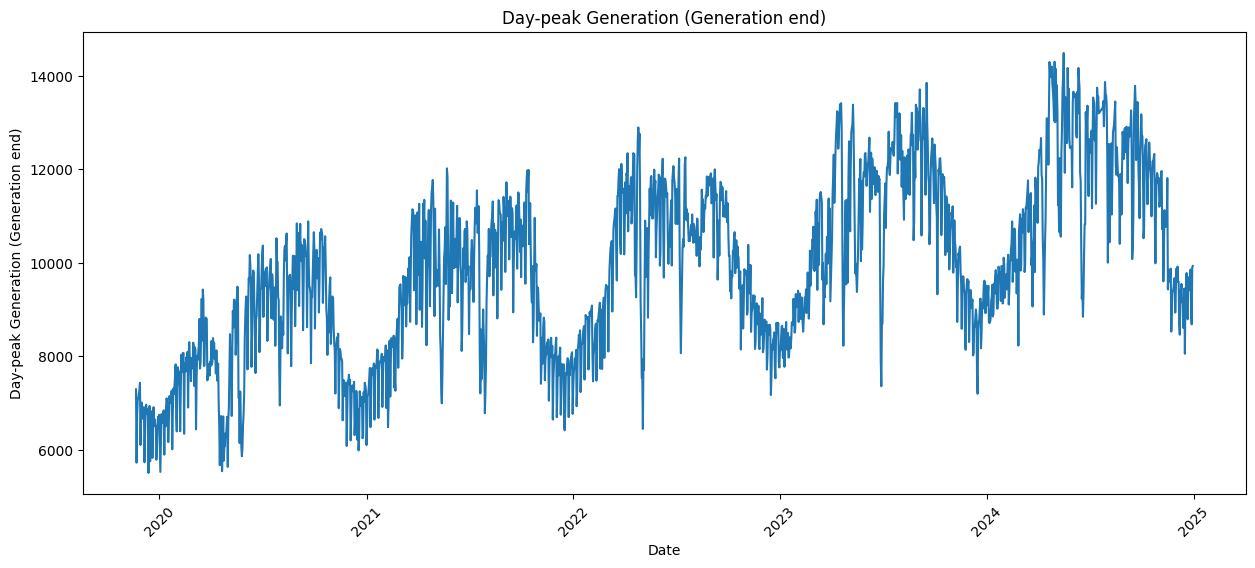

In [20]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='Date', y='Day-peak Generation (Generation end)', data=df)
plt.title('Day-peak Generation (Generation end)')
plt.xticks(rotation=45)
plt.show()

# Generation End vs Sub station end

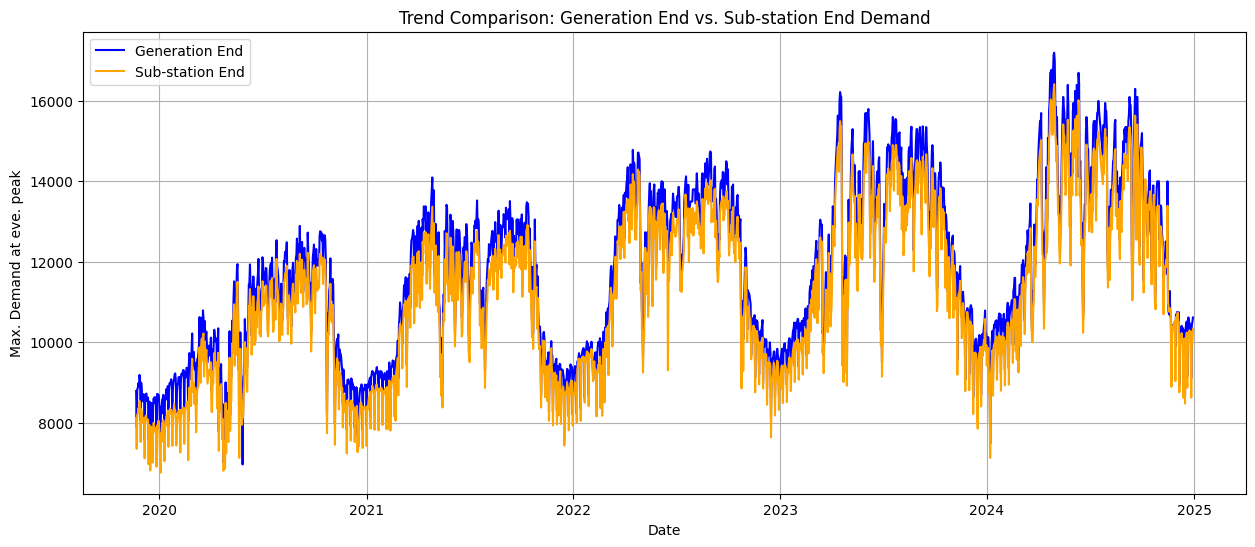

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Max. Demand at eve. peak (Generation end)'], label='Generation End', color='blue')
plt.plot(df['Date'], df['Max. Demand at eve. peak (Sub-station end)'], label='Sub-station End', color='orange')
plt.title('Trend Comparison: Generation End vs. Sub-station End Demand')
plt.xlabel('Date')
plt.ylabel('Max. Demand at eve. peak')
plt.legend()
plt.grid()
plt.show()